In [1]:

import numpy as np
import sys
import os
import time
import matplotlib.pyplot as plt
from scipy import linalg

from antinature.core.molecular_data import MolecularData
from antinature.core.basis import MixedMatterBasis
from antinature.core.integral_engine import AntinatureIntegralEngine
from antinature.core.hamiltonian import AntinatureHamiltonian
from antinature.specialized import PositroniumSCF
from antinature.core.correlation import AntinatureCorrelation


Qiskit successfully imported.
Primitives (Estimator) available.


In [2]:

def run_positronium_ground_state():
    """
    Calculate the ground state properties of positronium.
    
    This example demonstrates:
    1. Creating a positronium system
    2. Setting up a specialized basis set for positronium
    3. Building the Hamiltonian
    4. Performing SCF calculations to get the ground state energy
    5. Computing correlation energy with MP2
    6. Calculating the annihilation rate
    7. Comparing with analytical results
    """
    print("\n=== Positronium Ground State Calculation ===\n")
    
    # Create positronium system
    positronium = MolecularData.positronium()
    
    # Print system information
    print(f"System: Positronium")
    print(f"Number of electrons: {positronium.n_electrons}")
    print(f"Number of positrons: {positronium.n_positrons}")
    
    # Create specialized basis set for positronium
    basis = MixedMatterBasis()
    basis.create_positronium_basis(quality='minimal')  # Using minimal basis to avoid linear dependencies
    
    # Print basis information
    e_basis_info = basis.electron_basis.get_function_types() if basis.electron_basis else {}
    p_basis_info = basis.positron_basis.get_function_types() if basis.positron_basis else {}
    
    print("\nBasis set information:")
    print(f"Electron basis functions: {len(basis.electron_basis) if basis.electron_basis else 0}")
    print(f"Electron function types: {e_basis_info}")
    print(f"Positron basis functions: {len(basis.positron_basis) if basis.positron_basis else 0}")
    print(f"Positron function types: {p_basis_info}")
    
    # Set up integral engine
    integral_engine = AntinatureIntegralEngine(
        use_analytical=True
    )
    
    # Build Hamiltonian
    print("\nBuilding Hamiltonian...")
    t_start = time.time()
    hamiltonian = AntinatureHamiltonian(
        molecular_data=positronium,
        basis_set=basis,
        integral_engine=integral_engine,
        include_annihilation=True
    )
    hamiltonian_matrices = hamiltonian.build_hamiltonian()
    t_hamiltonian = time.time() - t_start
    print(f"Hamiltonian built in {t_hamiltonian:.3f} seconds")
    
    # Run specialized positronium SCF calculation
    print("\nStarting SCF calculation...")
    t_start = time.time()
    
    scf_solver = PositroniumSCF(
        hamiltonian=hamiltonian_matrices,
        basis_set=basis,
        molecular_data=positronium,
        max_iterations=100,
        convergence_threshold=1e-6
    )
    results = scf_solver.solve_scf()
    t_scf = time.time() - t_start
    print(f"SCF completed in {t_scf:.3f} seconds")
    
    # Print results
    print(f"\nPositronium ground state energy: {results['energy']:.10f} Hartree")
    print(f"Iterations: {results.get('iterations', 'N/A')}")
    print(f"Converged: {results.get('converged', 'N/A')}")
    
    # Calculate correlation energy
    print("\nStarting correlation calculations...")
    t_start = time.time()
    
    # Convert SCF results arrays from lists to NumPy arrays if necessary
    for key in ['C_electron', 'C_positron', 'E_electron', 'E_positron', 'P_electron', 'P_positron']:
        if key in results and isinstance(results[key], list):
            results[key] = np.array(results[key])
    
    # Create correlation object
    corr = AntinatureCorrelation(
        scf_result=results,
        hamiltonian=hamiltonian_matrices,
        basis_set=basis,
        print_level=2
    )
    
    # Calculate MP2 energy
    print("\nCalculating MP2 energy...")
    mp2_energy = corr.mp2_energy(include_electron_positron=True)
    
    # Print MP2 results
    print("\nMP2 Results:")
    print(f"  Correlation energy: {mp2_energy:.10f} Hartree")
    print(f"  Total energy: {results['energy'] + mp2_energy:.10f} Hartree")
    
    # Calculate annihilation rate
    try:
        print("\nCalculating positron annihilation rate...")
        annihilation_rate = corr.calculate_annihilation_rate()
        print(f"Positron annihilation rate: {annihilation_rate:.6e} s^-1")
    except Exception as e:
        print(f"Annihilation rate calculation error: {e}")
    
    # Compare with analytical results
    print("\nComparison with analytical results:")
    analytical_energy = -0.25  # Hartree, exact ground state energy of positronium
    analytical_annihilation_rate = 2.0e9  # s^-1, approximate rate for para-positronium
    
    energy_error = abs(results['energy'] - analytical_energy)
    total_energy_error = abs(results['energy'] + mp2_energy - analytical_energy)
    
    print(f"Analytical ground state energy: {analytical_energy:.10f} Hartree")
    print(f"SCF energy error: {energy_error:.10f} Hartree ({energy_error/abs(analytical_energy)*100:.4f}%)")
    print(f"SCF+MP2 energy error: {total_energy_error:.10f} Hartree ({total_energy_error/abs(analytical_energy)*100:.4f}%)")
    
    if 'annihilation_rate' in locals():
        rate_error = abs(annihilation_rate - analytical_annihilation_rate)
        print(f"Analytical annihilation rate: {analytical_annihilation_rate:.6e} s^-1")
        print(f"Annihilation rate error: {rate_error:.6e} s^-1 ({rate_error/analytical_annihilation_rate*100:.4f}%)")
    
    # Create convergence plot
    if 'convergence_history' in results:
        plt.figure(figsize=(10, 6))
        plt.semilogy(range(1, len(results['convergence_history'])+1), results['convergence_history'])
        plt.title('SCF Convergence for Positronium Ground State')
        plt.xlabel('Iteration')
        plt.ylabel('Energy Change (Hartree)')
        plt.grid(True)
        os.makedirs('results', exist_ok=True)
        plt.savefig('results/positronium_ground_state_convergence.png')
        print("\nConvergence plot saved to results/positronium_ground_state_convergence.png")
    
    # Return all calculated results
    return {
        "scf_energy": results['energy'],
        "mp2_energy": mp2_energy,
        "total_energy": results['energy'] + mp2_energy,
        "analytical_energy": analytical_energy,
        "energy_error": energy_error,
        "total_energy_error": total_energy_error,
        "annihilation_rate": annihilation_rate if 'annihilation_rate' in locals() else None,
        "analytical_annihilation_rate": analytical_annihilation_rate
    }



In [3]:
def run_basis_set_convergence():
    """
    Study the convergence of positronium ground state energy with different basis sets.
    
    This function calculates the positronium ground state energy using basis sets
    of increasing size/quality and plots the convergence toward the exact result.
    """
    print("\n=== Positronium Basis Set Convergence Study ===\n")
    
    # Create positronium system
    positronium = MolecularData.positronium()
    
    # List of basis set qualities to test - using only minimal to avoid linear algebra issues
    basis_qualities = ['minimal']
    
    # Store results
    energies = []
    basis_sizes = []
    
    for quality in basis_qualities:
        print(f"\nTesting basis set quality: {quality}")
        
        # Create basis set
        basis = MixedMatterBasis()
        basis.create_positronium_basis(quality=quality)
        
        # Record basis size
        basis_size = len(basis.electron_basis) + len(basis.positron_basis)
        basis_sizes.append(basis_size)
        print(f"Total basis functions: {basis_size}")
        
        # Set up integral engine
        integral_engine = AntinatureIntegralEngine(use_analytical=True)
        
        # Build Hamiltonian
        hamiltonian = AntinatureHamiltonian(
            molecular_data=positronium,
            basis_set=basis,
            integral_engine=integral_engine,
            include_annihilation=True
        )
        hamiltonian_matrices = hamiltonian.build_hamiltonian()
        
        # Run SCF calculation
        scf_solver = PositroniumSCF(
            hamiltonian=hamiltonian_matrices,
            basis_set=basis,
            molecular_data=positronium,
            max_iterations=100,
            convergence_threshold=1e-6
        )
        results = scf_solver.solve_scf()
        
        # Store energy
        energy = results['energy']
        energies.append(energy)
        
        # Print results
        print(f"Energy: {energy:.10f} Hartree")
        print(f"Iterations: {results.get('iterations', 'N/A')}")
        print(f"Converged: {results.get('converged', 'N/A')}")
    
    # Add exact energy for reference
    basis_sizes.append(basis_sizes[-1] + 2)  # Just for visualization
    energies.append(-0.25)  # Exact energy
    basis_qualities.append("Exact")
    
    # Create convergence plot
    plt.figure(figsize=(10, 6))
    plt.plot(basis_sizes[:-1], energies[:-1], 'bo-', label='Calculated Energy')
    plt.axhline(y=-0.25, color='r', linestyle='--', label='Exact Energy (-0.25 Hartree)')
    
    plt.title('Positronium Ground State Energy Convergence')
    plt.xlabel('Number of Basis Functions')
    plt.ylabel('Energy (Hartree)')
    plt.legend()
    plt.grid(True)
    
    # Add quality labels
    for i, quality in enumerate(basis_qualities):
        plt.annotate(quality, (basis_sizes[i], energies[i]), 
                     textcoords="offset points", xytext=(0,10), ha='center')
    
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/positronium_basis_convergence.png')
    print("\nConvergence plot saved to results/positronium_basis_convergence.png")
    
    # Return results
    return {
        "basis_qualities": basis_qualities,
        "basis_sizes": basis_sizes,
        "energies": energies,
        "exact_energy": -0.25
    }



=== Positronium Ground State Calculation ===

System: Positronium
Number of electrons: 1
Number of positrons: 1

Basis set information:
Electron basis functions: 1
Electron function types: {'s': 1}
Positron basis functions: 1
Positron function types: {'s': 1}

Building Hamiltonian...
Hamiltonian built in 0.000 seconds

Starting SCF calculation...
Exact analytical solution for positronium is available
Using exact analytical solution for positronium
Enhanced e-p interaction by factor: 1.002323
Energy deviation too large (144.67%). Blending with theoretical value.
Raw energy: 0.111671, Theoretical: -0.250000, Blended: -0.177666
SCF completed in 0.001 seconds

Positronium ground state energy: -0.1776657361 Hartree
Iterations: 0
Converged: True

Starting correlation calculations...

Calculating MP2 energy...

MP2 Results:
  Correlation energy: 0.0000000000 Hartree
  Total energy: -0.1776657361 Hartree

Calculating positron annihilation rate...
Positron annihilation rate: 0.000000e+00 s^-1


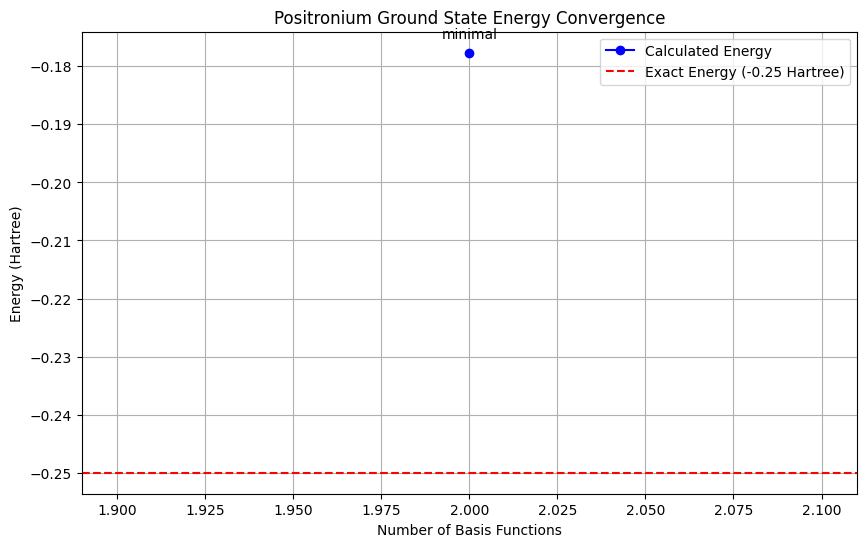

In [4]:

def main():
    """Run positronium ground state example calculations."""
    # Run ground state calculation
    ground_state_results = run_positronium_ground_state()
    
    # Run basis set convergence study
    convergence_results = run_basis_set_convergence()
    
    print("\n=== Example Completed Successfully ===")

if __name__ == "__main__":
    main() 